# CESM2-LE Initial Condition Memory:  Zonal-mean Z500
 - Use Intake to access CESM2LE data on glade
 - Compute zonal mean annual Z500 from CAM daily output for all members from 1850-2100
 - Plot Hovmuller of micro-to-total variance vs. time
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmZ500.nc'
if (exists(pp_datafile)):
    print(pp_datafile+' already exists. You can skip Section 1. \n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_zmZ500.nc already exists. You can skip Section 1. 




## Create Dask Cluster

In [71]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='50GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=50GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
cluster

# Section 1

## Data Intake

In [29]:
# Point to the catalog file
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [35]:
# Find CAM assets
camdata = col.search(component='atm', variable=['Z500'], frequency='day_1', experiment=['historical','ssp370'])

In [44]:
## Use preprocessor to return zonal mean
def preproc(ds):
    z500 = ds.Z500.mean('lon')
    dsout = z500.to_dataset()
    dsout['time_bnds'] = ds['time_bnds']
    return dsout

In [45]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
dsets = camdata.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 58.2 s, sys: 1.88 s, total: 1min
Wall time: 1min 10s


In [46]:
dsets.keys()

dict_keys(['atm.ssp370.cam.h1.smbb.Z500', 'atm.historical.cam.h1.cmip6.Z500', 'atm.ssp370.cam.h1.cmip6.Z500', 'atm.historical.cam.h1.smbb.Z500'])

In [47]:
dsets['atm.ssp370.cam.h1.smbb.Z500'].Z500

,Array,Chunk
Bytes,1.12 GiB,2.67 MiB
Shape,"(50, 31391, 192)","(1, 3650, 192)"
Count,3150 Tasks,450 Chunks
Type,float32,numpy.ndarray


## Data Processing

In [48]:
ds1 = calc.center_time(dsets['atm.historical.cam.h1.smbb.Z500'])
ds2 = calc.center_time(dsets['atm.ssp370.cam.h1.smbb.Z500'])
ds3 = calc.center_time(dsets['atm.historical.cam.h1.cmip6.Z500'])
ds4 = calc.center_time(dsets['atm.ssp370.cam.h1.cmip6.Z500'])

In [49]:
ds4.time

<xarray.DataArray 'time' (time: 31391)>
array([cftime.DatetimeNoLeap(2015, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 1, 2, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2100-12-31 12:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds
    note:       time recomputed as time_bnds.mean(nbnd)

Need to slice off first time index due to data file error:

In [50]:
ds1 = ds1.isel(time=slice(1,None))
ds2 = ds2.isel(time=slice(1,None))
ds3 = ds3.isel(time=slice(1,None))
ds4 = ds4.isel(time=slice(1,None))

#### Annual & Zonal Mean computation:

Here is the main computation:

In [51]:
%%time
ds1 = ds1.Z500.groupby('time.year').mean().rename({'year':'time'}).load()
ds2 = ds2.Z500.groupby('time.year').mean().rename({'year':'time'}).load()
ds3 = ds3.Z500.groupby('time.year').mean().rename({'year':'time'}).load()
ds4 = ds4.Z500.groupby('time.year').mean().rename({'year':'time'}).load()

CPU times: user 1min 39s, sys: 2.8 s, total: 1min 42s
Wall time: 5min 7s


In [52]:
## Create final Dataset:
work1 = xr.concat([ds3,ds4],dim='time')
work2 = xr.concat([ds1,ds2],dim='time')
cesm2le_zm = xr.concat([work1,work2],dim='member_id')
memid = cesm2le_zm.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le_zm.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le_zm.member_id})

ds = cesm2le_zm.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [53]:
pp_datafile

'/glade/scratch/yeager/cesm2_le/CESM2LE_zmZ500.nc'

In [54]:
%%time
ds.to_netcdf(pp_datafile)

CPU times: user 28 ms, sys: 8.98 ms, total: 37 ms
Wall time: 82 ms


<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [5]:
ds = xr.open_dataset(pp_datafile)
print('opening '+pp_datafile)

opening /glade/scratch/yeager/cesm2_le/CESM2LE_zmTREFHT.nc


In [55]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Start Year : Members
1011 : 001
1251 : 020
1091 : 001
1041 : 001
1231 : 020
1141 : 001
1191 : 001
1071 : 001
1151 : 001
1081 : 001
1181 : 001
1001 : 001
1121 : 001
1281 : 020
1061 : 001
1171 : 001
1051 : 001
1021 : 001
1031 : 001
1101 : 001
1131 : 001
1161 : 001
1111 : 001
1301 : 020


Apply low-pass filter:

In [56]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [57]:
ds['Z500'] = lpf_anndata(ds.Z500.transpose('time','member_id','lat'),period=15)

cutoff=  15.000000000000002  years


## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} + \sigma^{2}_{X,Cov(atm,ocn)}
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

For denominator, keep only the 4 20-member micro ensemble members (80 members total):

In [58]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = ds.Z500.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id')

In [59]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
covarlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.Z500.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    covar = (2*(da_oneinit - mean)*(mean-allmean)).mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
    covarlist.append(covar)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2
sig2_covar = xr.concat(covarlist,dim='p').mean('p')
# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi")
chi_covar = (sig2_covar/sig2_tot).rename("Chi")

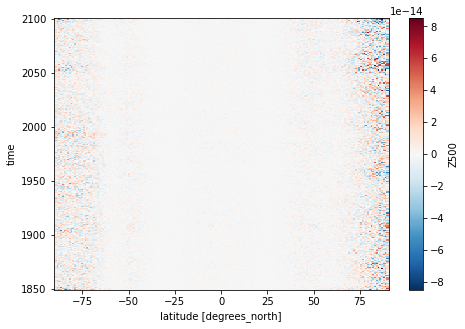

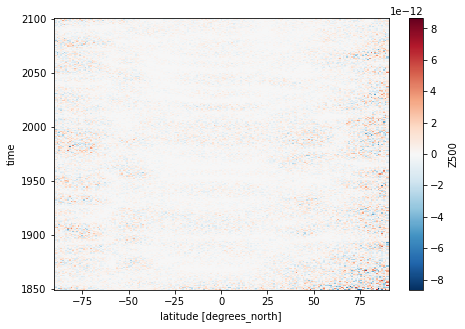

In [60]:
# Test for closure of variance budget:
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn+sig2_covar)
#sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2_resid.plot(size=5)
sig2_covar.plot(size=5)

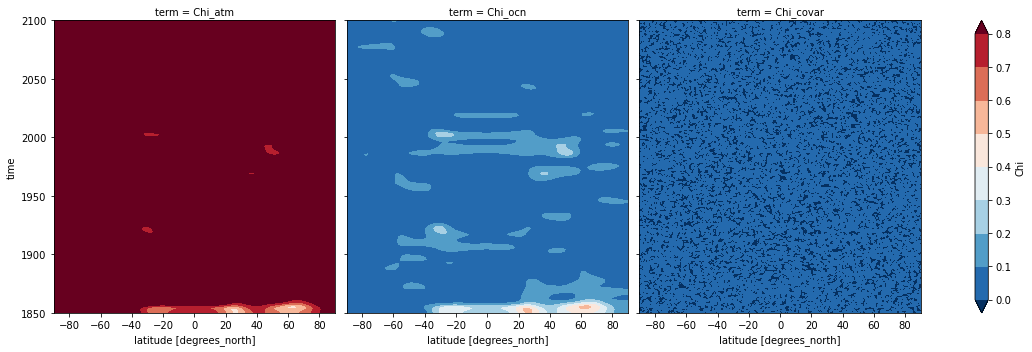

In [61]:
# Quick plot of Chi
chi = xr.concat([chi_atm,chi_ocn,chi_covar],dim=xr.DataArray(['Chi_atm','Chi_ocn','Chi_covar'],dims='term',name='term'))
levs = np.arange(0,9)*0.1
chi.plot.contourf(col='term',size=5,levels=levs)

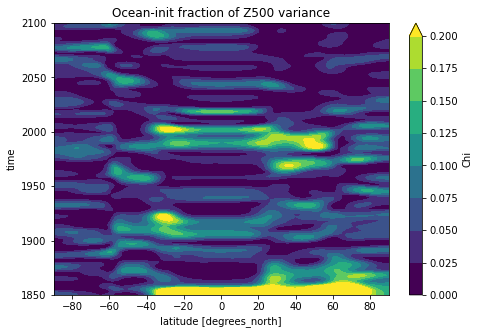

In [62]:
# Quick plot of Chi_ocn
levs = np.arange(0,9)*0.025
chi_ocn.plot.contourf(size=5,levels=levs)
plt.title('Ocean-init fraction of Z500 variance');

## Compute bootstrapped significance

In [63]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [64]:
iterations = 100
ens_size = 20
da_allmem_r = xs.resample_iterations(da_allmem, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

Now, resample to generate 1000 different 4-micro combinations:

In [65]:
da_allmem_rr = xs.resample_iterations(da_allmem_r, 1000, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn:

In [66]:
%%time
sig2_atm_r = da_allmem_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_allmem_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_allmem_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size

CPU times: user 11.9 s, sys: 2.07 s, total: 13.9 s
Wall time: 21 s


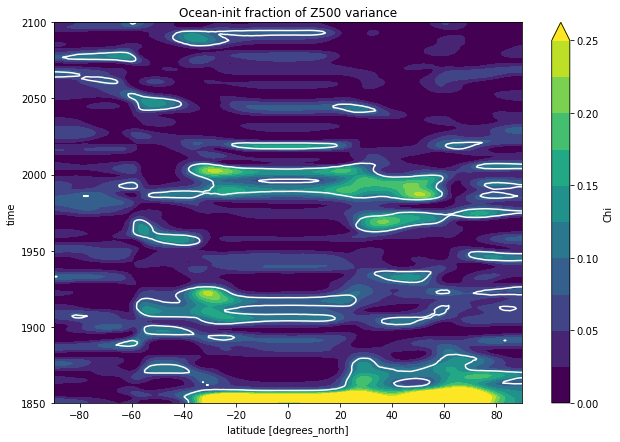

In [67]:
# Plot Chi_ocn with significance
levs = np.arange(0,11)*0.025
chi_ocn.plot.contourf(size=7,levels=levs)
pval.plot.contour(levels=[0.05],colors=['white'])
plt.title('Ocean-init fraction of Z500 variance');

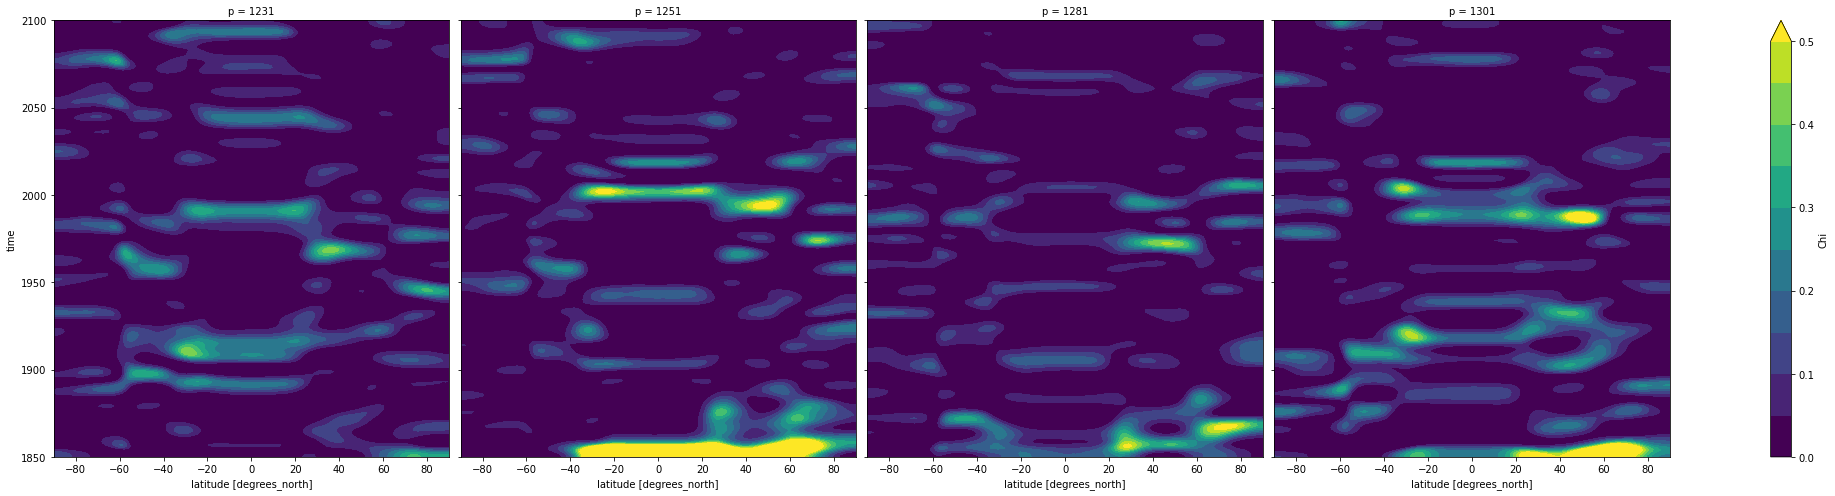

In [68]:
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',size=7,levels=levs)

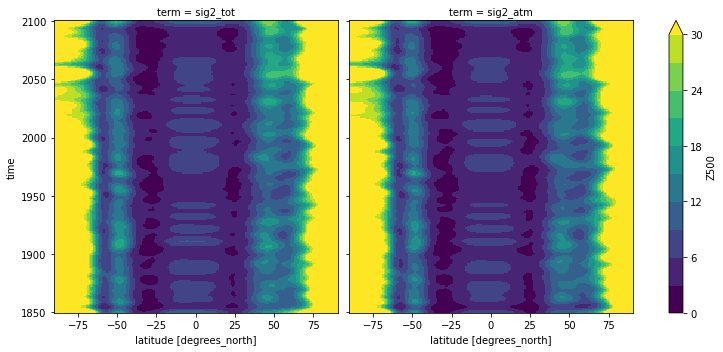

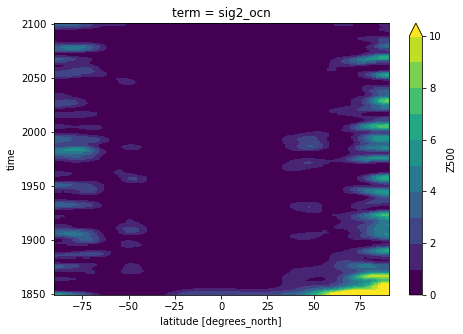

In [70]:
terms = xr.DataArray(['sig2_tot','sig2_atm','sig2_ocn','sig2_covar','sig2_residual'],dims='term',name='term')
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn+sig2_covar)
sig2 = xr.concat([sig2_tot,sig2_atm,sig2_ocn,sig2_covar,sig2_resid],dim=terms)

levs = np.arange(0,11)*3
sig2.isel(term=[0,1]).plot(col='term',col_wrap=2,size=5,levels=levs)
levs = np.arange(0,11)*1
sig2.isel(term=2).plot(size=5,levels=levs)